# Построение моделей для решения задачи классификации (бинарная)

## Импорт необходимых библиотек

In [3]:
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, auc
from scipy.stats import loguniform, uniform, randint

Загрузка датасета

Целевой признак - bomb_planted

In [4]:
data = pd.read_csv('csgo_filtred.csv')

y = data['bomb_planted']
X = data.drop(columns=['bomb_planted'], axis=1)

## Проверка баланса классов

In [5]:
X.head()

,time_left,ct_score,t_score,map,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,health_lead,armor_lead,money_lead,helmets_lead,players_alive_lead
0,175.00,0,0,de_dust2,500,500,0,0,4000,4000,0,0,0,5,5,2,2,2,2,2
1,156.03,0,0,de_dust2,500,500,400,300,600,650,0,0,1,5,5,2,0,1,2,2
2,96.03,0,0,de_dust2,391,400,294,200,750,500,0,0,1,4,4,1,0,0,2,2
3,76.03,0,0,de_dust2,391,400,294,200,750,500,0,0,1,4,4,1,0,0,2,2
4,174.97,1,0,de_dust2,500,500,192,0,18350,10750,0,0,1,5,5,2,0,0,2,2


<Axes: ylabel='bomb_planted'>

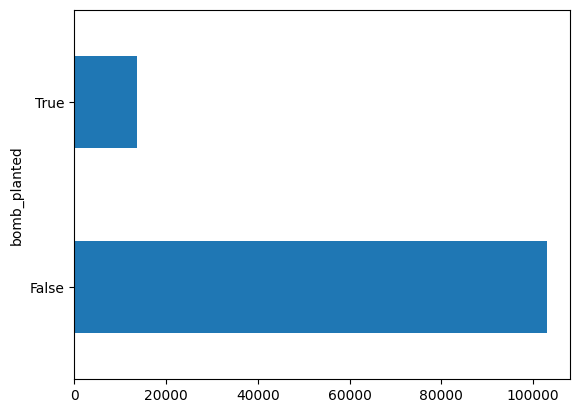

In [6]:
y.value_counts().plot.barh()

In [7]:
y.value_counts()

bomb_planted
False    102945
True      13684
Name: count, dtype: int64

Видно, что классы максимально несбалансированы, количество класса false превосходит класс true более чем в 5 раз.

Для балансировки буду использовать метод SMOTE, он создаёт дополнительные точки для минаритарного класса, основываясь на уже существующих точках.

Но для начала преобразую переменные признака map в числовые.

In [8]:
X['map'].value_counts()

map
de_inferno     22806
de_dust2       21040
de_nuke        17879
de_mirage      17641
de_overpass    13375
de_train       12800
de_vertigo     10733
unknown          211
de_cache         144
Name: count, dtype: int64

In [9]:
X['map'] = X['map'].str.strip().str.lower()

In [10]:
mapping = {
    'de_inferno': 1,
    'de_dust2': 2,
    'de_nuke': 3,
    'de_mirage': 4,
    'de_overpass': 5,
    'de_train': 6,
    'de_vertigo': 7,
    'unknown': 8,
    'de_cache': 9
}

X['map'] = X['map'].map(mapping)
X['map'].value_counts()

map
1    22806
2    21040
3    17879
4    17641
5    13375
6    12800
7    10733
8      211
9      144
Name: count, dtype: int64

In [11]:
oversample = SMOTE()
transformed_X, tranformed_y = oversample.fit_resample(X, y)

In [12]:
print(f'OLD: {y.value_counts()}')
print()
print(f'NEW: {tranformed_y.value_counts()}')

OLD: bomb_planted
False    102945
True      13684
Name: count, dtype: int64

NEW: bomb_planted
False    102945
True     102945
Name: count, dtype: int64


In [13]:
X, y = transformed_X, tranformed_y

In [14]:
X.duplicated().sum()

np.int64(0)

Как можно увидеть балансировка по классам получилась успешной, теперь мы имеем два класса с одинаковым количеством точек.

## Разделение на тренировочную и тестовую выборки

In [15]:
# Метод train_test_split с использованием stratify

X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.5, stratify=y, test_size=0.1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((102945, 20), (102945,), (20589, 20), (20589,))

In [16]:
X_train_search, X_test_search, y_train_search, y_test_search = train_test_split(X, y, random_state=42, train_size=0.05, stratify=y, test_size=0.01)
X_train_search.shape, y_train_search.shape, X_test_search.shape, y_test_search.shape

((10294, 20), (10294,), (2059, 20), (2059,))

In [17]:
# KFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [18]:
# Маштабирование

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_search = scaler.fit_transform(X_train_search)
X_test_search = scaler.transform(X_test_search)

## Вычисление лучший гиперпараметров для моделей

По заданию необходимо использовать такие модели классификации как:

- `Logistic Regression`
- `kNN`
- `Naive Bayes`
- `SVM` (в том числе ядерные функции (Linear Kernel, Polynomial Kernel, RBF Kernel, Sigmoid Kernel, Exponential Kernel))

Для начала найду для всех этих моделей лучшие гиперпараметры

`ВАЖНО!` Датасет после балансировки классов состоит из 200тыс объектов, искать гиперпараметры на таком объёмы это потрать дни, поэтому в самом начале специально были созданы выборки по 10тыс объектов для поиска гиперпараметров, далее применяя наиденные гиперпараметры в моделях, буду обучать их на 100тыс объектах.

In [19]:
from search_hyperparameters import search_hyperparameters

In [20]:
models = ['LogisticRegression', 'kNN', 'NaiveBayes', 'SVM']
methods = ['GridSearchCV', 'RandomizedSearchCV']

parameters = {
    'LogisticRegression': {
        'GridSearchCV': {
            'C': [0.001, 0.01, 0.1, 1, 10],
            'penalty': ['l2', 'l1'],
            'solver': ['liblinear', 'saga'],
            'class_weight': [None, 'balanced'],
            'tol': [1e-4, 1e-3]
        },
        'RandomizedSearchCV': {
            'C': loguniform(1e-4, 1e2),
            'penalty': ['l2', 'l1'],
            'solver': ['liblinear', 'saga'],
            'class_weight': [None, 'balanced'],
            'tol': uniform(1e-4, 1e-2)
        }
    },
    'kNN': {
        'GridSearchCV': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        },
        'RandomizedSearchCV': {
            'n_neighbors': randint(3, 15),
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },
    'NaiveBayes': {
        'GridSearchCV': {
            'var_smoothing': [1e-9, 1e-8, 1e-7]
        },
        'RandomizedSearchCV': {
            'var_smoothing': loguniform(1e-9, 1e-6)
        }
    },
    'SVM': {
        'GridSearchCV': {
            'kernel': ['linear', 'rbf'],
            'C': [0.1, 1, 10],
            'gamma': ['scale', 0.001, 0.01]
        },
        'RandomizedSearchCV': {
            'kernel': ['linear', 'rbf'],
            'C': loguniform(1e-2, 1e2),
            'gamma': loguniform(1e-4, 1e-1)
        }
    }
}


In [21]:
best_params = {}

for model in models:
    best_params[model] = {}
    for method in methods:
        print(f'Сейчас на {model}, {method}')
        searcher = search_hyperparameters(
            model_name=model,
            method_search=method,
            X_train=X_train_search,
            y_train=y_train_search,
            param_grid=parameters[model][method],
            n_jobs=-1,
            cv=3,
            scoring='accuracy'
        )
        best_params[model][method] = {
            'params': searcher['best_params'],
            'score': searcher['best_score']
        }

Сейчас на LogisticRegression, GridSearchCV
Сейчас на LogisticRegression, RandomizedSearchCV
Сейчас на kNN, GridSearchCV
Сейчас на kNN, RandomizedSearchCV
Сейчас на NaiveBayes, GridSearchCV
Сейчас на NaiveBayes, RandomizedSearchCV
Сейчас на SVM, GridSearchCV
Сейчас на SVM, RandomizedSearchCV


In [22]:
best_params

{'LogisticRegression': {'GridSearchCV': {'params': {'C': 1,
    'class_weight': None,
    'penalty': 'l1',
    'solver': 'liblinear',
    'tol': 0.001},
   'score': np.float64(0.9484170335962817)},
  'RandomizedSearchCV': {'params': {'C': np.float64(2.300772379610957),
    'class_weight': None,
    'penalty': 'l1',
    'solver': 'saga',
    'tol': np.float64(0.004463858975144203)},
   'score': np.float64(0.948222726785828)}},
 'kNN': {'GridSearchCV': {'params': {'metric': 'manhattan',
    'n_neighbors': 9,
    'weights': 'distance'},
   'score': np.float64(0.9197584492323635)},
  'RandomizedSearchCV': {'params': {'metric': 'manhattan',
    'n_neighbors': 14,
    'weights': 'distance'},
   'score': np.float64(0.9213128187916878)}},
 'NaiveBayes': {'GridSearchCV': {'params': {'var_smoothing': 1e-09},
   'score': np.float64(0.919078800017302)},
  'RandomizedSearchCV': {'params': {'var_smoothing': np.float64(4.1692152672389864e-07)},
   'score': np.float64(0.919078800017302)}},
 'SVM': {'G

Сохранение словаря как json файла, чтобы не вычислять его повторно

In [27]:
def convert(o):
    if isinstance(o, np.generic):
        return o.item()
    raise TypeError

with open('best_params.json', 'w') as f:
    json.dump(best_params, f, indent=4, default=convert)

with open('best_params.json', 'r') as f:
    best_params = json.load(f)

## Обучение моделей

In [28]:
def metrics(pred_array, true_array=y_test,):
    print(f'F1: {f1_score(true_array, pred_array)}')
    print(f'accuracy: {accuracy_score(true_array, pred_array)}')
    print(f'precision: {precision_score(true_array, pred_array)}')
    print(f'recall: {recall_score(true_array, pred_array)}')
    print(f'roc_auc_score: {roc_auc_score(true_array, pred_array)}')

Logistic Regression

In [29]:
model_lr = LogisticRegression(
    max_iter=10000, 
    penalty=best_params['LogisticRegression']['GridSearchCV']['params']['penalty'],
    solver=best_params['LogisticRegression']['GridSearchCV']['params']['solver'],
    tol=best_params['LogisticRegression']['GridSearchCV']['params']['tol'],
    C=best_params['LogisticRegression']['GridSearchCV']['params']['C']
    )
# Hold-out
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
metrics(y_pred_lr)
# CV
scores_lr = cross_val_score(model_lr, X_train, y_train, cv=kf, scoring='accuracy')
print(f'Оценка кросс-валидации: {scores_lr.mean()}')

F1: 0.9539983825698112
accuracy: 0.9530331730535723
precision: 0.9347441036636525
recall: 0.9740625607149797
roc_auc_score: 0.9530341943934296
Оценка кросс-валидации: 0.9506435475253777


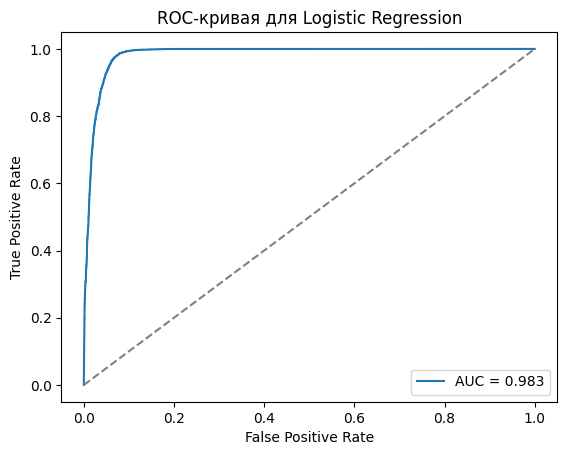

In [30]:
y_prob_lr = model_lr.predict_proba(X_test)[:, 1]

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f'AUC = {roc_auc_lr:.3f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для Logistic Regression')
plt.legend(loc='lower right')
plt.show()


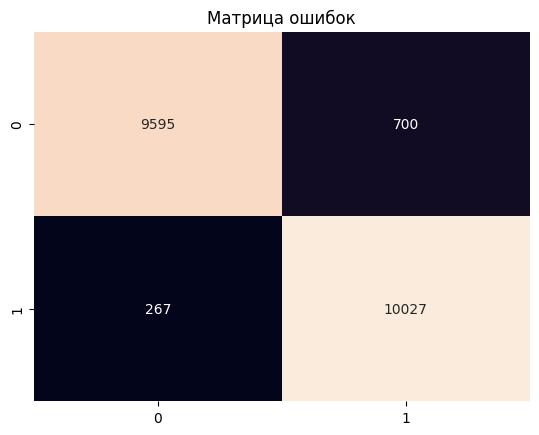

In [ ]:
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure()
sns.heatmap(cm_lr, annot=True, fmt='d', cbar=False)
plt.title('Матрица ошибок')
plt.show()

kNN

In [32]:
model_knn = KNeighborsClassifier(
    n_neighbors=best_params['kNN']['GridSearchCV']['params']['n_neighbors'],
    weights=best_params['kNN']['GridSearchCV']['params']['weights'],
    metric=best_params['kNN']['GridSearchCV']['params']['metric']
)
# Hold-out
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)
metrics(y_pred_knn)
# CV
scores_knn = cross_val_score(model_knn, X_train, y_train, cv=kf, scoring='accuracy')
print(f'Оценка кросс-валидации: {scores_knn.mean()}')

F1: 0.952385428907168
accuracy: 0.9507989703239594
precision: 0.9225935707130498
recall: 0.9841655333203808
roc_auc_score: 0.9508005908466887
Оценка кросс-валидации: 0.9455145951721793


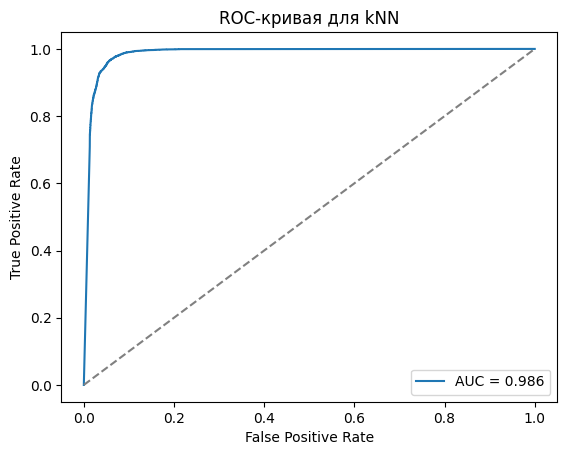

In [ ]:
y_prob_knn = model_knn.predict_proba(X_test)[:, 1]

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure()
plt.plot(fpr_knn, tpr_knn, label=f'AUC = {roc_auc_knn:.3f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для kNN')
plt.legend(loc='lower right')
plt.show()

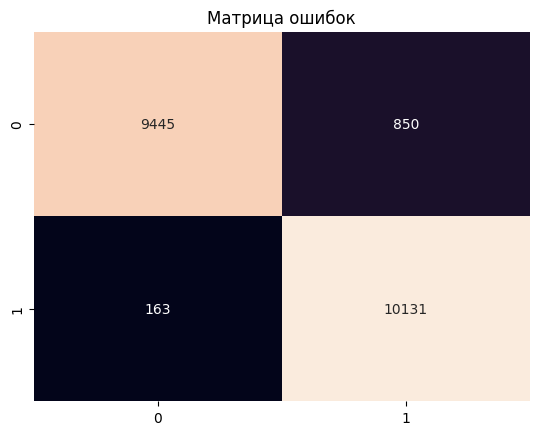

In [ ]:
cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure()
sns.heatmap(cm_knn, annot=True, fmt='d', cbar=False)
plt.title('Матрица ошибок')
plt.show()

Naive Bayes

In [35]:
model_nb = GaussianNB(
    var_smoothing=1e-09
)
# Hold-out
model_nb.fit(X_train, y_train)
y_pred_nb = model_nb.predict(X_test)
metrics(y_pred_nb)
# CV
scores_nb = cross_val_score(model_nb, X_train, y_train, cv=kf, scoring='accuracy')
print(f'Оценка кросс-валидации: {scores_nb.mean()}')

F1: 0.9207529187514891
accuracy: 0.919228714362038
precision: 0.9036572818258348
recall: 0.9385078686613562
roc_auc_score: 0.9192296506978466
Оценка кросс-валидации: 0.9181698965466996


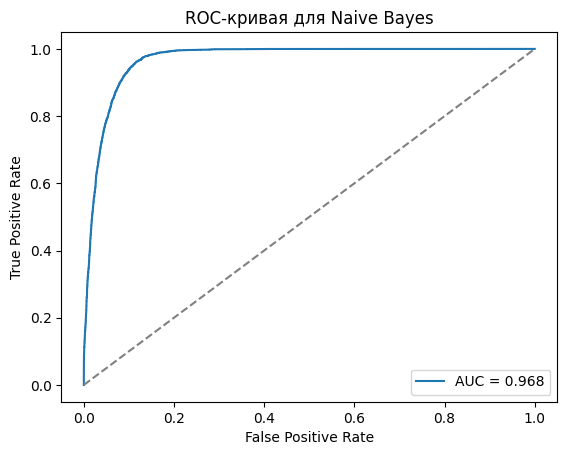

In [36]:
y_prob_nb = model_nb.predict_proba(X_test)[:, 1]

fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

plt.figure()
plt.plot(fpr_nb, tpr_nb, label=f'AUC = {roc_auc_nb:.3f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для Naive Bayes')
plt.legend(loc='lower right')
plt.show()

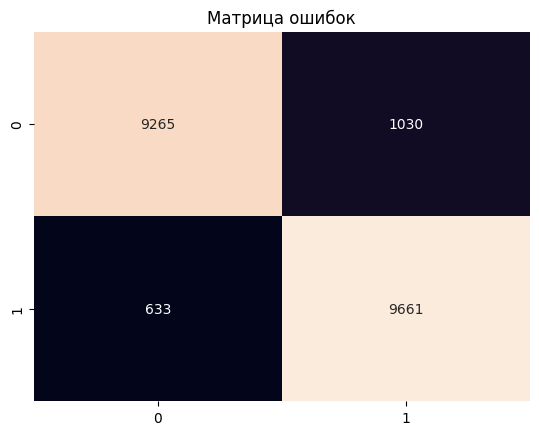

In [37]:
cm_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure()
sns.heatmap(cm_nb, annot=True, fmt='d', cbar=False)
plt.title('Матрица ошибок')
plt.show()

In [38]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']

SVC(rbf)

In [ ]:
model_svc_rbf = SVC(
    C=best_params['SVM']['GridSearchCV']['params']['C'],
    gamma=best_params['SVM']['GridSearchCV']['params']['gamma'],
    kernel='rbf',
    probability=True
)
# Hold-out
model_svc_rbf.fit(X_train, y_train)
y_pred_svc_rbf = model_svc_rbf.predict(X_test)
metrics(y_pred_svc_rbf)
# CV
score_svc_rbf = cross_val_score(model_svc_rbf, X_train, y_train, cv=2, scoring='accuracy')
print(f'Оценка кросс-валидации: {score_svc_rbf.mean()}')

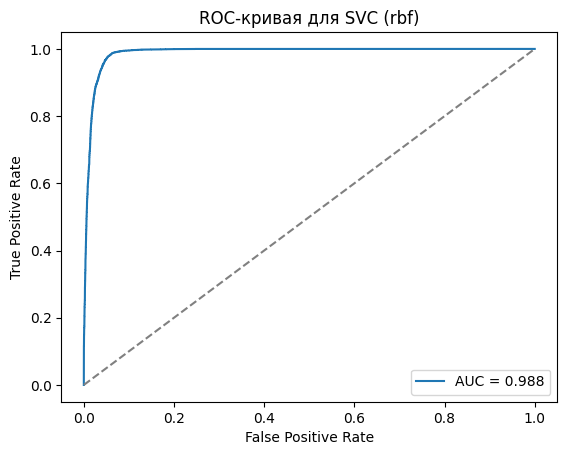

In [ ]:
y_prob_svc_rbf = model_svc_rbf.predict_proba(X_test)[:, 1]

fpr_svc_rbf, tpr_svc_rbf, _ = roc_curve(y_test, y_prob_svc_rbf)
roc_auc_svc_rbf = auc(fpr_svc_rbf, tpr_svc_rbf)

plt.figure()
plt.plot(fpr_svc_rbf, tpr_svc_rbf, label=f'AUC = {roc_auc_svc_rbf:.3f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для SVC (rbf)')
plt.legend(loc='lower right')
plt.show()

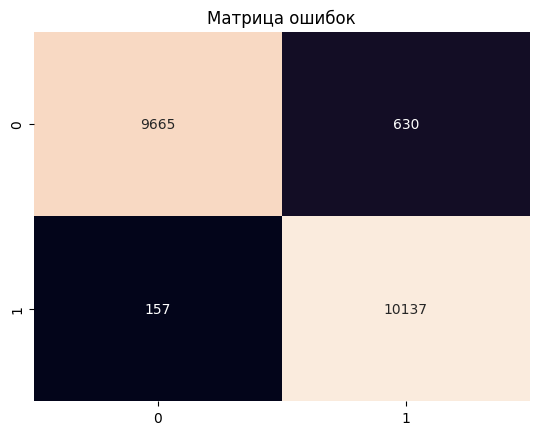

In [ ]:
cm_svc_rbf = confusion_matrix(y_test, y_pred_svc_rbf)

plt.figure()
sns.heatmap(cm_svc_rbf, annot=True, fmt='d', cbar=False)
plt.title('Матрица ошибок')
plt.show()